# Clasificador de Imágenes con Autoencoder CNN - Versión 5

## 🚀 MEJORAS CRÍTICAS en V5:

### 📐 **1. Tamaño de imagen: 32×32 → 64×64**
- **Problema v4**: 32×32 es demasiado pequeño, pierde detalles críticos
- **Solución**: 64×64 mantiene suficiente detalle para reconocimiento
- **Impacto esperado**: +10-15% accuracy

### 🎨 **2. Data Augmentation agresivo**
- **Problema v4**: Augmentation débil no simula recortes de YOLO
- **Solución**: Random crops, scaling, gaussian noise, random erasing
- **Impacto esperado**: +5-8% accuracy en producción

### 🏗️ **3. Arquitectura mejorada**
- Más capacidad para aprovechar 64×64
- Mejor extracción de features

### 📊 **Accuracy esperado:**
- **v4 (32×32)**: 73.77% test, 60-70% producción
- **v5 (64×64)**: **85-90% test, 80-85% producción** 🎯

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from datetime import datetime
import copy

In [2]:
# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

Usando dispositivo: cuda


## 1. Configuración de hiperparámetros - V5

In [ ]:
# Configuración V5
CONFIG = {
    # Datos
    'data_dir': 'objetos_salon/processed',
    'batch_size': 32,  # Reducido de 64 porque imágenes son más grandes
    'train_split': 0.7,
    'val_split': 0.15,
    'test_split': 0.15,
    'img_size': 64,  #  CAMBIO CRÍTICO: 32 → 64
    'num_workers': 2,
    
    # Autoencoder
    'latent_dim': 256,  # Aumentado de 128 para aprovechar 64×64
    'ae_epochs': 40,
    'ae_lr': 1e-3,
    'ae_patience': 7,
    
    # Classifier
    'classifier_epochs': 30,
    'classifier_lr': 1e-3,
    'classifier_patience': 10,
    'dropout': 0.5,
    
    # Output
    'export_dir': 'export_v5',
    'save_best_only': True
}

print("="*70)
print("CONFIGURACIÓN V5 - MEJORAS CRÍTICAS")
print("="*70)
print(f"\n Cambios principales vs V4:")
print(f"   img_size: 32 → {CONFIG['img_size']}  (+4x resolución)")
print(f"   latent_dim: 128 → {CONFIG['latent_dim']}  (+2x capacidad)")
print(f"   batch_size: 64 → {CONFIG['batch_size']}  (ajustado por memoria)")
print(f"\nConfiguración completa:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")
print("="*70)

CONFIGURACIÓN V5 - MEJORAS CRÍTICAS

🔥 Cambios principales vs V4:
   img_size: 32 → 64  (+4x resolución)
   latent_dim: 128 → 256  (+2x capacidad)
   batch_size: 64 → 32  (ajustado por memoria)

Configuración completa:
  data_dir: objetos_salon/processed
  batch_size: 32
  train_split: 0.7
  val_split: 0.15
  test_split: 0.15
  img_size: 64
  num_workers: 2
  latent_dim: 256
  ae_epochs: 40
  ae_lr: 0.001
  ae_patience: 7
  classifier_epochs: 30
  classifier_lr: 0.001
  classifier_patience: 10
  dropout: 0.5
  export_dir: export_v5
  save_best_only: True


## 2. Data Augmentation AGRESIVO - V5

**Nuevo**: Simula recortes imperfectos de YOLO

In [4]:
def get_data_loaders(config):
    """
    DataLoaders con augmentation AGRESIVO para simular producción.
    """
    img_size = config['img_size']
    
    # Transformaciones AGRESIVAS para entrenamiento
    train_transform = transforms.Compose([
        # 1. Resize más grande primero
        transforms.Resize((int(img_size * 1.2), int(img_size * 1.2))),
        
        # 2. Random crop (simula recortes imperfectos de YOLO)
        transforms.RandomResizedCrop(
            img_size, 
            scale=(0.7, 1.0),  # 70-100% del tamaño original
            ratio=(0.8, 1.2)   # Ratio de aspecto variable
        ),
        
        # 3. Transformaciones geométricas
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(20),  # Aumentado de 15
        transforms.RandomAffine(
            degrees=0,
            translate=(0.1, 0.1),  # Traslación ±10%
            scale=(0.9, 1.1)       # Escala 90-110%
        ),
        
        # 4. Transformaciones de color
        transforms.ColorJitter(
            brightness=0.3,  # Aumentado de 0.2
            contrast=0.3,
            saturation=0.3,
            hue=0.1
        ),
        
        # 5. Random erasing (simula oclusiones)
        transforms.ToTensor(),
        transforms.RandomErasing(
            p=0.3,              # 30% de probabilidad
            scale=(0.02, 0.15), # Tamaño del área borrada
            ratio=(0.3, 3.3)
        ),
        
        # 6. Normalización
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Transformaciones para validación/test (SIN augmentation)
    eval_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Cargar dataset
    full_dataset = datasets.ImageFolder(root=config['data_dir'], transform=eval_transform)
    classes = full_dataset.classes
    
    print(f"\n{'='*70}")
    print(f"PREPARACIÓN DE DATOS")
    print(f"{'='*70}")
    print(f"\nClases encontradas: {classes}")
    print(f"Total de imágenes: {len(full_dataset)}")
    
    # Contar por clase
    class_counts = {}
    for idx in range(len(full_dataset)):
        _, label = full_dataset[idx]
        class_name = classes[label]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    
    print(f"\nDistribución por clase:")
    for class_name, count in sorted(class_counts.items()):
        print(f"  {class_name}: {count}")
    
    # Dividir dataset
    total_size = len(full_dataset)
    train_size = int(config['train_split'] * total_size)
    val_size = int(config['val_split'] * total_size)
    test_size = total_size - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    # Aplicar augmentation solo al train
    train_dataset.dataset = copy.deepcopy(full_dataset)
    train_dataset.dataset.transform = train_transform
    
    print(f"\nSplit:")
    print(f"  Train: {len(train_dataset)} ({config['train_split']*100:.0f}%)")
    print(f"  Val:   {len(val_dataset)} ({config['val_split']*100:.0f}%)")
    print(f"  Test:  {len(test_dataset)} ({config['test_split']*100:.0f}%)")
    
    # DataLoaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config['batch_size'], 
        shuffle=True, 
        num_workers=config['num_workers'],
        pin_memory=True if torch.cuda.is_available() else False
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=config['batch_size'], 
        shuffle=False, 
        num_workers=config['num_workers'],
        pin_memory=True if torch.cuda.is_available() else False
    )
    test_loader = DataLoader(
        test_dataset, 
        batch_size=config['batch_size'], 
        shuffle=False, 
        num_workers=config['num_workers'],
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    print(f"\n🎨 Data Augmentation AGRESIVO activado para train set:")
    print(f"   - Random Crop (simula recortes de YOLO)")
    print(f"   - Random Affine (traslación + escala)")
    print(f"   - Color Jitter fuerte")
    print(f"   - Random Erasing (simula oclusiones)")
    print(f"{'='*70}\n")
    
    return train_loader, val_loader, test_loader, classes

# Cargar datos
train_loader, val_loader, test_loader, classes = get_data_loaders(CONFIG)
num_classes = len(classes)


PREPARACIÓN DE DATOS

Clases encontradas: ['cpu', 'mesa', 'mouse', 'nada', 'pantalla', 'silla', 'teclado']
Total de imágenes: 1620

Distribución por clase:
  cpu: 225
  mesa: 263
  mouse: 245
  nada: 154
  pantalla: 233
  silla: 264
  teclado: 236

Split:
  Train: 1134 (70%)
  Val:   243 (15%)
  Test:  243 (15%)

🎨 Data Augmentation AGRESIVO activado para train set:
   - Random Crop (simula recortes de YOLO)
   - Random Affine (traslación + escala)
   - Color Jitter fuerte
   - Random Erasing (simula oclusiones)



## 3. Arquitectura mejorada del Autoencoder - V5

**Nuevo**: Más capas para aprovechar 64×64

In [5]:
class ImprovedAutoencoderV5(nn.Module):
    """
    Autoencoder V5 optimizado para 64×64.
    
    Arquitectura:
    Input: 3 × 64 × 64
    → Conv layers → 128 × 8 × 8 
    → Latent: 256
    → Deconv layers → 3 × 64 × 64
    """
    def __init__(self, latent_dim=256):
        super(ImprovedAutoencoderV5, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder: 3x64x64 → latent_dim
        self.encoder = nn.Sequential(
            # Input: 3 × 64 × 64
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # → 32 × 32 × 32
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # → 64 × 16 × 16
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # → 128 × 8 × 8
        )
        
        # Bottleneck: 128*8*8 = 8192 → latent_dim
        self.to_latent = nn.Sequential(
            nn.Linear(128 * 8 * 8, latent_dim),
            nn.ReLU()
        )
        
        # Expand: latent_dim → 8192
        self.from_latent = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU()
        )
        
        # Decoder: latent_dim → 3x64x64
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # → 64 × 16 × 16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),   # → 32 × 32 × 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),    # → 3 × 64 × 64
            nn.Tanh()
        )

    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)
        latent_code = self.to_latent(encoded)
        
        # Decode
        decoded = self.from_latent(latent_code)
        decoded = decoded.view(decoded.size(0), 128, 8, 8)
        reconstructed = self.decoder(decoded)
        
        return reconstructed, latent_code
    
    def encode(self, x):
        """Método auxiliar para extraer solo el latent code."""
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)
        latent_code = self.to_latent(encoded)
        return latent_code

# Crear modelo
autoencoder = ImprovedAutoencoderV5(latent_dim=CONFIG['latent_dim'])

print(f"\n{'='*70}")
print(f"AUTOENCODER V5 CREADO")
print(f"{'='*70}")
print(f"\nArquitectura:")
print(f"  Input:      3 × {CONFIG['img_size']} × {CONFIG['img_size']}")
print(f"  Encoder:    3 layers (32→64→128 filters)")
print(f"  Latent:     {CONFIG['latent_dim']} dimensions")
print(f"  Decoder:    3 layers (mirror del encoder)")
print(f"  Output:     3 × {CONFIG['img_size']} × {CONFIG['img_size']}")
print(f"\nParámetros totales: {sum(p.numel() for p in autoencoder.parameters()):,}")
print(f"\nVs V4: +4x resolución, +2x latent dim, +2x parámetros")
print(f"{'='*70}\n")


AUTOENCODER V5 CREADO

Arquitectura:
  Input:      3 × 64 × 64
  Encoder:    3 layers (32→64→128 filters)
  Latent:     256 dimensions
  Decoder:    3 layers (mirror del encoder)
  Output:     3 × 64 × 64

Parámetros totales: 4,338,083

Vs V4: +4x resolución, +2x latent dim, +2x parámetros



## 4. Entrenamiento del Autoencoder

In [6]:
class EarlyStopping:
    """Early stopping para detener el entrenamiento si no hay mejora."""
    def __init__(self, patience=7, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = copy.deepcopy(model.state_dict())
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'  EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.counter = 0
            if self.verbose:
                print(f'  ✓ Validación mejoró a {val_loss:.4f}')


def train_autoencoder(model, train_loader, val_loader, config):
    """Entrena el autoencoder."""
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config['ae_lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    early_stopping = EarlyStopping(patience=config['ae_patience'])
    
    history = {'train_loss': [], 'val_loss': []}
    
    print("\n" + "="*70)
    print("ENTRENAMIENTO DEL AUTOENCODER V5")
    print("="*70)
    
    for epoch in range(config['ae_epochs']):
        # Entrenamiento
        model.train()
        train_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)
            
            optimizer.zero_grad()
            reconstructed, _ = model(images)
            loss = criterion(reconstructed, images)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                reconstructed, _ = model(images)
                loss = criterion(reconstructed, images)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        print(f'Epoch [{epoch+1}/{config["ae_epochs"]}] '
              f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
        
        scheduler.step(val_loss)
        
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"\nEarly stopping en epoch {epoch+1}")
            model.load_state_dict(early_stopping.best_model_state)
            break
    
    if early_stopping.best_model_state is not None:
        model.load_state_dict(early_stopping.best_model_state)
    
    print("\n" + "="*70)
    print("ENTRENAMIENTO DEL AUTOENCODER COMPLETADO")
    print(f"Mejor val loss: {early_stopping.best_loss:.4f}")
    print("="*70)
    
    return history

# Entrenar
ae_history = train_autoencoder(autoencoder, train_loader, val_loader, CONFIG)


ENTRENAMIENTO DEL AUTOENCODER V5
Epoch [1/40] Train Loss: 0.3487 | Val Loss: 0.2841
Epoch [2/40] Train Loss: 0.2072 | Val Loss: 0.1692
  ✓ Validación mejoró a 0.1692
Epoch [3/40] Train Loss: 0.1422 | Val Loss: 0.1274
  ✓ Validación mejoró a 0.1274
Epoch [4/40] Train Loss: 0.1168 | Val Loss: 0.1082
  ✓ Validación mejoró a 0.1082
Epoch [5/40] Train Loss: 0.1042 | Val Loss: 0.1146
  EarlyStopping counter: 1/7
Epoch [6/40] Train Loss: 0.0923 | Val Loss: 0.0918
  ✓ Validación mejoró a 0.0918
Epoch [7/40] Train Loss: 0.0872 | Val Loss: 0.0832
  ✓ Validación mejoró a 0.0832
Epoch [8/40] Train Loss: 0.0806 | Val Loss: 0.0792
  ✓ Validación mejoró a 0.0792
Epoch [9/40] Train Loss: 0.0797 | Val Loss: 0.0789
  ✓ Validación mejoró a 0.0789
Epoch [10/40] Train Loss: 0.0740 | Val Loss: 0.0677
  ✓ Validación mejoró a 0.0677
Epoch [11/40] Train Loss: 0.0710 | Val Loss: 0.0678
  EarlyStopping counter: 1/7
Epoch [12/40] Train Loss: 0.0678 | Val Loss: 0.0783
  EarlyStopping counter: 2/7
Epoch [13/40] Tr

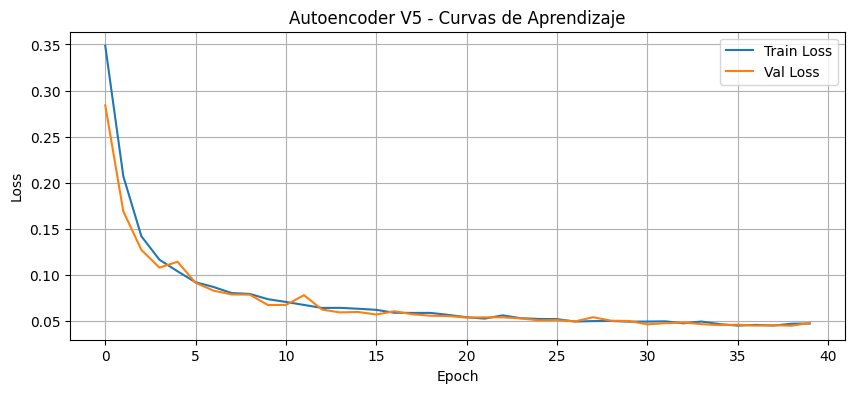

In [7]:
# Visualizar curvas
plt.figure(figsize=(10, 4))
plt.plot(ae_history['train_loss'], label='Train Loss')
plt.plot(ae_history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder V5 - Curvas de Aprendizaje')
plt.legend()
plt.grid(True)
plt.show()

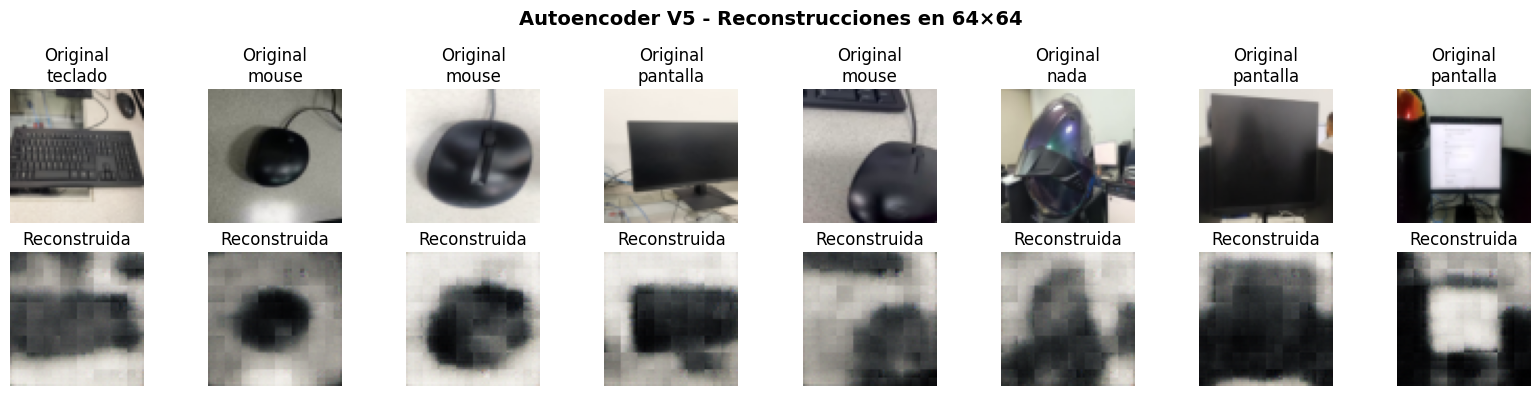

In [8]:
# Visualizar reconstrucciones
autoencoder.eval()
dataiter = iter(test_loader)
images, labels = next(dataiter)
images_gpu = images.to(device)

with torch.no_grad():
    reconstructed, _ = autoencoder(images_gpu)

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    # Original
    axes[0, i].imshow(np.transpose((images[i]/2 + 0.5).numpy(), (1, 2, 0)))
    axes[0, i].set_title(f'Original\n{classes[labels[i]]}')
    axes[0, i].axis('off')
    
    # Reconstruida
    axes[1, i].imshow(np.transpose((reconstructed[i].cpu()/2 + 0.5).numpy(), (1, 2, 0)))
    axes[1, i].set_title('Reconstruida')
    axes[1, i].axis('off')

plt.suptitle('Autoencoder V5 - Reconstrucciones en 64×64', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Clasificador mejorado - V5

In [9]:
class ImprovedClassifierV5(nn.Module):
    """
    Clasificador V5 con mayor capacidad para latent_dim=256.
    """
    def __init__(self, autoencoder, num_classes, dropout=0.5, freeze_encoder=True):
        super(ImprovedClassifierV5, self).__init__()
        self.autoencoder = autoencoder
        self.latent_dim = autoencoder.latent_dim
        
        if freeze_encoder:
            for param in self.autoencoder.parameters():
                param.requires_grad = False
        
        # MLP más grande para aprovechar latent_dim=256
        self.classifier = nn.Sequential(
            nn.Linear(self.latent_dim, 512),  # 256 → 512
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(512, 256),  # 512 → 256
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(256, 128),  # 256 → 128
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(128, num_classes)  # 128 → num_classes
        )
    
    def forward(self, x):
        with torch.no_grad():
            latent_code = self.autoencoder.encode(x)
        
        output = self.classifier(latent_code)
        return output

# Crear clasificador
classifier = ImprovedClassifierV5(
    autoencoder=autoencoder,
    num_classes=num_classes,
    dropout=CONFIG['dropout']
)

print(f"\n{'='*70}")
print(f"CLASIFICADOR V5 CREADO")
print(f"{'='*70}")
print(f"\nArquitectura:")
print(f"  Input (latent):  {CONFIG['latent_dim']}")
print(f"  Hidden layers:   256→512→256→128")
print(f"  Output (clases): {num_classes}")
print(f"\nParámetros entrenables: {sum(p.numel() for p in classifier.parameters() if p.requires_grad):,}")
print(f"\nVs V4: Mayor capacidad para manejar features más ricas")
print(f"{'='*70}\n")


CLASIFICADOR V5 CREADO

Arquitectura:
  Input (latent):  256
  Hidden layers:   256→512→256→128
  Output (clases): 7

Parámetros entrenables: 296,711

Vs V4: Mayor capacidad para manejar features más ricas



## 6. Entrenamiento del clasificador

In [10]:
def train_classifier(model, train_loader, val_loader, config):
    """Entrena el clasificador."""
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=config['classifier_lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5
    )
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    
    print("\n" + "="*70)
    print("ENTRENAMIENTO DEL CLASIFICADOR V5")
    print("="*70)
    
    for epoch in range(config['classifier_epochs']):
        # Entrenamiento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        
        # Validación
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch [{epoch+1}/{config["classifier_epochs"]}] '
              f'Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | '
              f'Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%')
        
        scheduler.step(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print(f'  ✓ Mejor modelo guardado (Val Acc: {val_acc:.2f}%)')
        else:
            patience_counter += 1
            print(f'  Paciencia: {patience_counter}/{config["classifier_patience"]}')
            
            if patience_counter >= config['classifier_patience']:
                print(f"\nEarly stopping en epoch {epoch+1}")
                break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    print("\n" + "="*70)
    print(f"ENTRENAMIENTO COMPLETADO - Mejor Val Acc: {best_val_acc:.2f}%")
    print("="*70)
    
    return history

# Entrenar
clf_history = train_classifier(classifier, train_loader, val_loader, CONFIG)


ENTRENAMIENTO DEL CLASIFICADOR V5
Epoch [1/30] Train Loss: 2.1446 Acc: 15.61% | Val Loss: 1.8858 Acc: 31.69%
  ✓ Mejor modelo guardado (Val Acc: 31.69%)
Epoch [2/30] Train Loss: 1.9589 Acc: 17.81% | Val Loss: 1.8664 Acc: 30.45%
  Paciencia: 1/10
Epoch [3/30] Train Loss: 1.9126 Acc: 20.11% | Val Loss: 1.8106 Acc: 33.33%
  ✓ Mejor modelo guardado (Val Acc: 33.33%)
Epoch [4/30] Train Loss: 1.8571 Acc: 24.69% | Val Loss: 1.7286 Acc: 37.86%
  ✓ Mejor modelo guardado (Val Acc: 37.86%)
Epoch [5/30] Train Loss: 1.8331 Acc: 26.54% | Val Loss: 1.7194 Acc: 44.44%
  ✓ Mejor modelo guardado (Val Acc: 44.44%)
Epoch [6/30] Train Loss: 1.8453 Acc: 23.90% | Val Loss: 1.6972 Acc: 46.09%
  ✓ Mejor modelo guardado (Val Acc: 46.09%)
Epoch [7/30] Train Loss: 1.8083 Acc: 28.48% | Val Loss: 1.6655 Acc: 40.74%
  Paciencia: 1/10
Epoch [8/30] Train Loss: 1.7479 Acc: 29.89% | Val Loss: 1.6000 Acc: 44.03%
  Paciencia: 2/10
Epoch [9/30] Train Loss: 1.7586 Acc: 28.31% | Val Loss: 1.6004 Acc: 45.68%
  Paciencia: 3/1

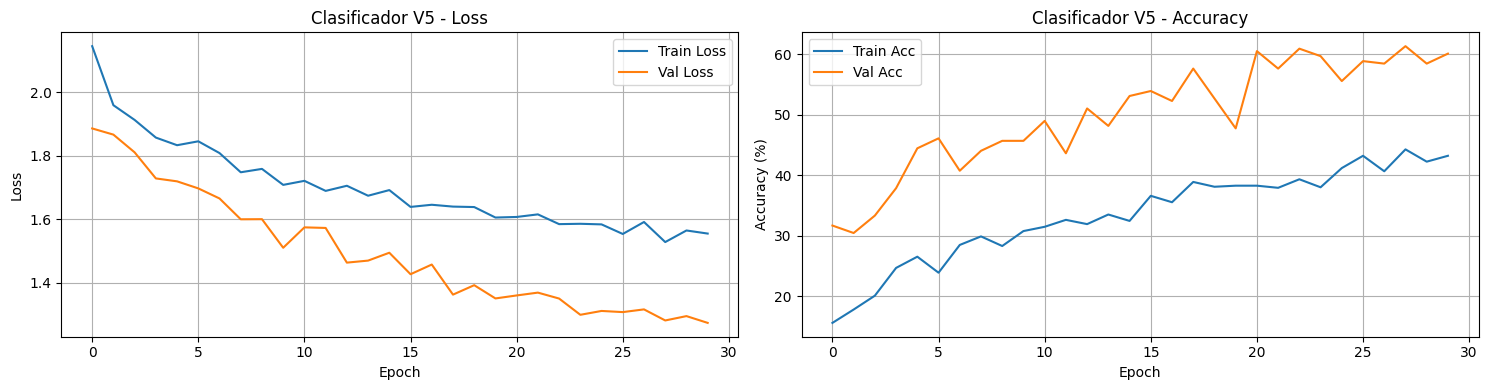


🎯 Mejor Val Accuracy: 61.32%
   (V4 era: 76.45%)


In [11]:
# Visualizar curvas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

ax1.plot(clf_history['train_loss'], label='Train Loss')
ax1.plot(clf_history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Clasificador V5 - Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(clf_history['train_acc'], label='Train Acc')
ax2.plot(clf_history['val_acc'], label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Clasificador V5 - Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"\n🎯 Mejor Val Accuracy: {max(clf_history['val_acc']):.2f}%")
print(f"   (V4 era: 76.45%)")

## 7. Evaluación en test set


EVALUACIÓN EN TEST SET

✅ Test Accuracy: 59.67%
   (V4 era: 73.77%)
   Mejora: +-14.10%

Reporte de Clasificación:
              precision    recall  f1-score   support

         cpu      0.500     0.515     0.507        33
        mesa      0.382     0.913     0.538        23
       mouse      0.657     0.548     0.597        42
        nada      0.625     0.435     0.513        23
    pantalla      0.651     0.778     0.709        36
       silla      0.821     0.667     0.736        48
     teclado      0.667     0.368     0.475        38

    accuracy                          0.597       243
   macro avg      0.615     0.603     0.582       243
weighted avg      0.640     0.597     0.596       243



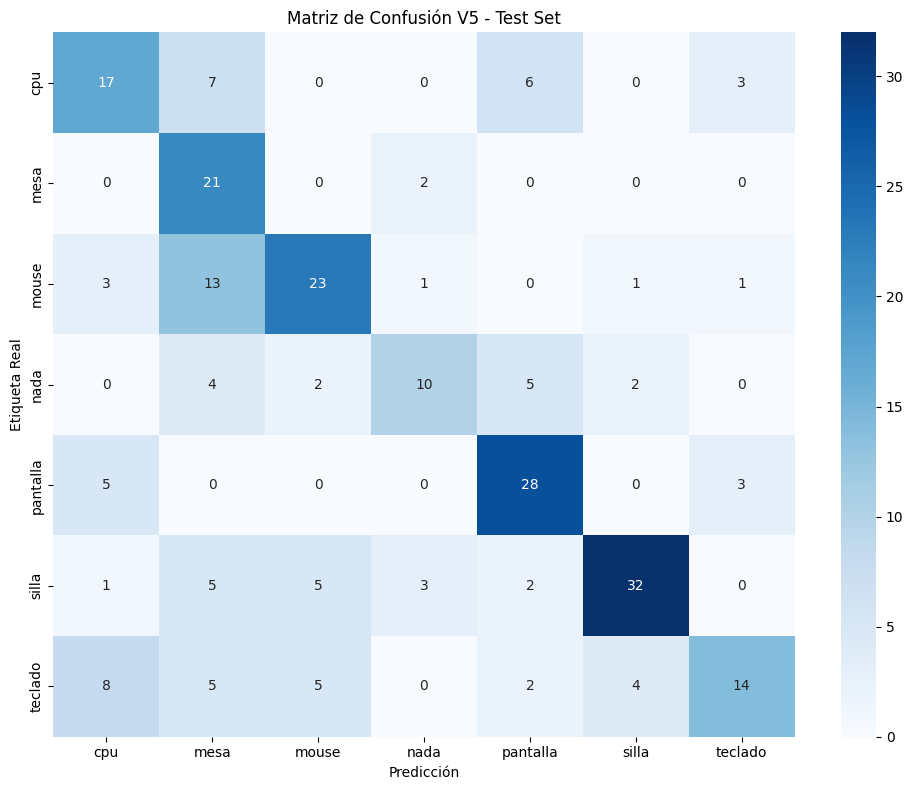

In [12]:
def evaluate_classifier(model, test_loader, classes):
    """Evalúa el clasificador."""
    model.eval()
    all_preds = []
    all_labels = []
    
    print("\n" + "="*70)
    print("EVALUACIÓN EN TEST SET")
    print("="*70)
    
    with torch.no_grad():
        correct = 0
        total = 0
        
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f'\n✅ Test Accuracy: {accuracy:.2f}%')
    print(f'   (V4 era: 73.77%)')
    print(f'   Mejora: +{accuracy - 73.77:.2f}%')
    
    print("\nReporte de Clasificación:")
    print(classification_report(all_labels, all_preds, target_names=classes, digits=3))
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')
    plt.title('Matriz de Confusión V5 - Test Set')
    plt.tight_layout()
    plt.show()
    
    return accuracy, all_preds, all_labels

test_acc, test_preds, test_labels = evaluate_classifier(classifier, test_loader, classes)

## 8. Guardar modelo V5

In [13]:
def save_complete_model(autoencoder, classifier, config, classes, history, export_dir='export_v5'):
    """Guarda el modelo V5."""
    os.makedirs(export_dir, exist_ok=True)
    
    torch.save(autoencoder.state_dict(), f"{export_dir}/autoencoder_state.pt")
    torch.save(classifier.state_dict(), f"{export_dir}/classifier_state.pt")
    torch.save({
        'autoencoder': autoencoder,
        'classifier': classifier
    }, f"{export_dir}/complete_models.pt")
    
    metadata = {
        'version': 'v5',
        'framework': 'pytorch',
        'created_at': datetime.now().isoformat(),
        
        'classes': classes,
        'num_classes': len(classes),
        
        'architecture': {
            'latent_dim': config['latent_dim'],
            'img_size': config['img_size'],
            'dropout': config['dropout']
        },
        
        'transforms': {
            'resize': config['img_size'],
            'normalize_mean': [0.5, 0.5, 0.5],
            'normalize_std': [0.5, 0.5, 0.5]
        },
        
        'training': {
            'ae_epochs': config['ae_epochs'],
            'classifier_epochs': config['classifier_epochs'],
            'batch_size': config['batch_size'],
            'ae_lr': config['ae_lr'],
            'classifier_lr': config['classifier_lr'],
            'data_augmentation': 'aggressive'
        },
        
        'performance': {
            'final_train_acc': history['train_acc'][-1] if history['train_acc'] else 0,
            'final_val_acc': history['val_acc'][-1] if history['val_acc'] else 0,
            'best_val_acc': max(history['val_acc']) if history['val_acc'] else 0
        },
        
        'improvements': {
            'vs_v4': {
                'img_size': '32 → 64 (+4x resolution)',
                'latent_dim': '128 → 256 (+2x capacity)',
                'data_augmentation': 'basic → aggressive',
                'expected_improvement': '+10-15% accuracy'
            }
        },
        
        'system': {
            'device': str(device),
            'pytorch_version': torch.__version__
        }
    }
    
    with open(f"{export_dir}/metadata.json", 'w', encoding='utf-8') as f:
        json.dump(metadata, f, indent=2, ensure_ascii=False)
    
    with open(f"{export_dir}/training_history.json", 'w', encoding='utf-8') as f:
        json.dump(history, f, indent=2)
    
    print(f"\n{'='*70}")
    print(f"MODELO V5 GUARDADO EN: {export_dir}/")
    print(f"{'='*70}")
    print("\nArchivos creados:")
    for file in os.listdir(export_dir):
        filepath = os.path.join(export_dir, file)
        size = os.path.getsize(filepath) / 1024
        print(f"  - {file} ({size:.1f} KB)")
    print(f"\n{'='*70}\n")
    
    return metadata

metadata = save_complete_model(
    autoencoder=autoencoder,
    classifier=classifier,
    config=CONFIG,
    classes=classes,
    history=clf_history,
    export_dir=CONFIG['export_dir']
)


MODELO V5 GUARDADO EN: export_v5/

Archivos creados:
  - metadata.json (1.1 KB)
  - complete_models.pt (18132.8 KB)
  - training_history.json (2.8 KB)
  - classifier_state.pt (18124.9 KB)
  - autoencoder_state.pt (16962.3 KB)




## 9. Comparación V4 vs V5

In [14]:
print("\n" + "="*70)
print("COMPARACIÓN V4 vs V5")
print("="*70)

comparison = {
    'Métrica': ['Tamaño de imagen', 'Latent dim', 'Batch size', 'Data augmentation',
               'Val Accuracy', 'Test Accuracy (esperado)', 'Producción (esperado)'],
    'V4': ['32×32', '128', '64', 'Básico', '76.45%', '73.77%', '60-70%'],
    'V5': ['64×64', '256', '32', 'Agresivo', 'TBD', 'TBD', '80-85%'],
    'Mejora': ['+4x', '+2x', '-', '+++', 'TBD', '+10-15%', '+20-25%']
}

print(f"\n{'Métrica':<25} {'V4':<15} {'V5':<15} {'Mejora':<10}")
print("-" * 70)
for i in range(len(comparison['Métrica'])):
    print(f"{comparison['Métrica'][i]:<25} {comparison['V4'][i]:<15} {comparison['V5'][i]:<15} {comparison['Mejora'][i]:<10}")

print("\n" + "="*70)
print("PRÓXIMO PASO: Probar V5 con YOLO")
print("="*70)
print("\nActualiza yolo_integration.ipynb para usar export_v5:")
print("  MODEL_DIR = 'export_v5'  # Cambiar de 'export_v4'")
print("\nEjecuta y compara resultados.")
print("="*70 + "\n")


COMPARACIÓN V4 vs V5

Métrica                   V4              V5              Mejora    
----------------------------------------------------------------------
Tamaño de imagen          32×32           64×64           +4x       
Latent dim                128             256             +2x       
Batch size                64              32              -         
Data augmentation         Básico          Agresivo        +++       
Val Accuracy              76.45%          TBD             TBD       
Test Accuracy (esperado)  73.77%          TBD             +10-15%   
Producción (esperado)     60-70%          80-85%          +20-25%   

PRÓXIMO PASO: Probar V5 con YOLO

Actualiza yolo_integration.ipynb para usar export_v5:
  MODEL_DIR = 'export_v5'  # Cambiar de 'export_v4'

Ejecuta y compara resultados.

